# Pipeline for High-z Radio Galaxies 21: Analysis of predictions. Scores and Metrics

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
import pandas as pd

In [2]:
mpl.rcdefaults()

Create path effects

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

Define specific metrics for redshift values.

In [4]:
def sigma_mad(z_true, z_pred, **kwargs):
    med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    return 1.48 * med

In [5]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    med  = np.nanmedian(np.abs(frac)).astype('float32')
    return 1.48 * med

In [6]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [7]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [8]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    siz  = np.sum(np.isfinite(dif)).astype('float32')
    num  = np.sum(np.array(dif > 0.15)).astype('float32')
    frac = num / siz
    return frac

Method to create confusion matrices

In [9]:
def conf_mat_func(true_class, predicted_class):
    cm = np.array([[np.sum(np.array(true_class == 0) & np.array(predicted_class == 0)),\
                    np.sum(np.array(true_class == 0) & np.array(predicted_class == 1))],\
                   [np.sum(np.array(true_class == 1) & np.array(predicted_class == 0)),\
                    np.sum(np.array(true_class == 1) & np.array(predicted_class == 1))]])
    return cm

Methods for the use of values in Confusion Matrices.

In [10]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [11]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [12]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [13]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

Method to plot confusion matrix

In [14]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal', values_format=',')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(28)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

Method to plot predicted and true redshift values

In [15]:
def plot_redshift_compare(true_z, predicted_z, ax_pre, title=None, dpi=10, cmap='cet_linear_kryw_5_100_c64_r', show_clb=False, log_stretch=False):
    if log_stretch:
        norm = ImageNormalize(vmin=0., stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(vmin=0., stretch=PowerStretch(1.1))

    filt_pair_z   = np.isfinite(true_z) & np.isfinite(predicted_z)
    max_for_range = np.nanmax([np.nanmax(1 + true_z.loc[filt_pair_z]), np.nanmax(1 + predicted_z.loc[filt_pair_z])])

    dens_1 = ax_pre.scatter_density((1 + true_z.sample(frac=1, random_state=seed)),\
            (1 + predicted_z.sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap(cmap), zorder=0, dpi=dpi, norm=norm, alpha=0.93)
    
    ax_pre.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)

    if show_clb:
        clb = plt.colorbar(dens_1, extend='neither', norm=norm, ticks=ticker.MaxNLocator(integer=True))
        clb.ax.tick_params(labelsize=14)
        clb.outline.set_linewidth(2.5)
        clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

    # Inset axis with residuals
    axins = inset_axes(ax_pre, width='35%', height='20%', loc=2)
    res_z_z = (predicted_z - true_z) / (1 + true_z)
    axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)
    axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
    axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')
    axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
    axins.tick_params(labelleft=False, labelbottom=True)
    axins.tick_params(which='both', top=True, right=True, direction='in')
    axins.tick_params(axis='both', which='major', labelsize=10)
    axins.tick_params(which='major', length=8, width=1.5)
    axins.tick_params(which='minor', length=4, width=1.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    axins.set_xlim(left=-0.9, right=0.9)
    ##
    ax_pre.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='minor', labelsize=14)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    # ax_pre.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax_pre.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_pre.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    ax_pre.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_xlim(left=1., right=np.ceil(max_for_range))
    ax_pre.set_ylim(bottom=1., top=np.ceil(max_for_range))
    ax_pre.set_title(title)
    plt.tight_layout()

Method to plot metrics over redshift

In [16]:
def plot_metric_over_z(z_range, metric_range, name_metric, ax_pre, title=None, color=plt.get_cmap('cmr.redshift')(0.8)):
    ax_pre.plot(z_range, metric_range, color=color, zorder=10, alpha=0.93, marker='o', ls='-', lw=2.5)
    ##
    ax_pre.set_xlabel('$z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel(f'$\mathrm{{{name_metric}}} (\geq z)$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='major', labelsize=16)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_title(title)
    ax_pre.grid(visible=True, alpha=0.1, zorder=0)
    plt.tight_layout()

In [17]:
def plot_metric_threshold(thresh_range, metric_range, name_metric, ax_pre, title=None, color=plt.get_cmap('cmr.redshift')(0.8)):
    ax_pre.plot(thresh_range, metric_range, color=color, zorder=10, alpha=0.93, marker='o', ls='-', lw=2.5)
    ax_pre.axvline(x=0.5, marker=None, ls='--', lw=2.0, color='Gray')
    ##
    ax_pre.set_xlabel('Classification Threshold', fontsize=20)
    ax_pre.set_ylabel(f'$\mathrm{{{name_metric}}} (\geq \mathrm{{threshold}})$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='major', labelsize=16)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_title(title)
    ax_pre.grid(visible=True, alpha=0.1, zorder=0)
    plt.tight_layout()

Methods for Pycaret

In [18]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        try:
            for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
            return sample_df.columns.tolist()
        except:
            for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
            return sample_df.columns.tolist()

In [19]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

Methods to create values of metrics by redshift ranges

In [20]:
def z_metric_in_z_ranges(data_set_df, z_col, z_range, metric_function, *metricArgs):
    metric_output  = np.zeros_like(z_range)
    true_vals      = metricArgs[0]
    predicted_vals = metricArgs[1]
    for count, z_thresh in enumerate(z_range):
        filter_z             = data_set_df.loc[:, z_col] >= z_thresh
        if np.sum(filter_z) == 0:
            metric_output[count] = np.nan
            continue
        sub_set              = data_set_df.loc[filter_z, [*metricArgs]]
        metric_output[count] = metric_function(sub_set.loc[:, true_vals], sub_set.loc[:, predicted_vals])
    return metric_output

In [21]:
def class_metric_in_z_ranges(data_set_df, z_col, z_range, metric_function, *metricArgs):
    metric_output   = np.zeros_like(z_range)
    true_class      = metricArgs[0]
    predicted_class = metricArgs[1]
    for count, z_thresh in enumerate(z_range):
        filter_z             = data_set_df.loc[:, z_col] >= z_thresh
        if np.sum(filter_z) == 0:
            metric_output[count] = np.nan
            continue
        sub_set              = data_set_df.loc[filter_z, [*metricArgs]]
        sub_cm               = conf_mat_func(sub_set.loc[:, true_class], sub_set.loc[:, predicted_class])
        metric_output[count] = metric_function(sub_cm)
    return metric_output

In [22]:
def metric_over_threshold(dataframe, true_class, score_col, thresh_ranges, metric_function):  # for classification
    out_metric            = np.zeros_like(thresh_ranges)
    for count, threshold in enumerate(thresh_ranges):
        temp_pred_class   = np.array(dataframe.loc[:, score_col] >= threshold).astype(int)
        temp_cm           = conf_mat_func(dataframe.loc[:, true_class], temp_pred_class)
        temp_metric       = metric_function(temp_cm)
        out_metric[count] = temp_metric
    return out_metric

---

In [23]:
save_plot_flag      = False
load_models_flag    = True
use_second_z_model  = True

### Load data

In [24]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

In [25]:
used_area           = 'S82'  # can be 'S82', 'HETDEX', 'COSMOS' 

In [26]:
file_S82            = 'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_HETDEX         = 'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'
file_COSMOS         = 'CatWISE2020_COSMOS_MILLIQUAS_7_4d_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'

file_name_dict      = {'S82': file_S82, 'HETDEX': file_HETDEX, 'COSMOS': file_COSMOS}
file_name           = file_name_dict[used_area]

In [27]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [28]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [29]:
full_catalog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369093 entries, 0 to 369092
Data columns (total 50 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   RA_ICRS       369093 non-null  float32
 1   DE_ICRS       369093 non-null  float32
 2   Name          369093 non-null  object 
 3   TYPE          369093 non-null  object 
 4   Z             2930 non-null    float32
 5   zsp           665 non-null     float32
 6   spCl          369093 non-null  object 
 7   band_num      369093 non-null  int64  
 8   radio_detect  369093 non-null  bool   
 9   is_str        369093 non-null  int64  
 10  is_AGN        369093 non-null  int64  
 11  is_SDSS_gal   369093 non-null  int64  
 12  is_gal        369093 non-null  int64  
 13  W1mproPM      369093 non-null  float32
 14  W2mproPM      369093 non-null  float32
 15  gmag          369093 non-null  float32
 16  rmag          369093 non-null  float32
 17  imag          369093 non-null  float32
 18  zmag

Create features with class and combined redshift.

In [30]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
filter_non_confirmed                = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) | np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [31]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

In [32]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

##### Random seed

In [33]:
seed                                = 42

### Load models

In [34]:
if load_models_flag:
    AGN_gal_clf     = pyc.load_model('models/classification_AGN_galaxy_may_15_2022')
    # radio_det_clf   = pyc.load_model('models/classification_radio_detect_may_16_2022')  # With predicted AGN
    radio_det_clf   = pyc.load_model('models/classification_radio_detect_ago_02_2022')  # Without predicted AGN
    redshift_reg    = pyr.load_model('models/regression_z_may_17_2022')  # to use on full sample
    if use_second_z_model:
        # redshift_reg_2  = pyr.load_model('models/regression_z_may_18_2022')  # to use on sources with predicted z >= 2
        # redshift_reg_2  = pyr.load_model('models/regression_z_jun_01_2022')  # to use on sources with predicted z >= 3.7+SMOGN
        redshift_reg_2  = pyr.load_model('models/regression_z_jul_19_2022')  # to use on sources with predicted z >= 3.7+SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [35]:
threshold_AGN   = 0.3112  # 0.5, 0.3094 from ROC AUC in train+test, 0.3112 from PR curve
threshold_radio = 3.45872868e-01  # 0.5, 4.99972232e-01, 3.45872868e-01 from ROC AUC in train+test and PR curve

##### Predictions

In [36]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=threshold_AGN, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [37]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=threshold_radio, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [38]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=3)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [39]:
redshift_lim    = 3.6
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=3)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [40]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

---

#### Confusion matrices

In [41]:
cm_AGN = np.array([[np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0) & np.array(full_catalog_df.loc[:, 'pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0) & np.array(full_catalog_df.loc[:, 'pred_class'] == 1))],\
                   [np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'pred_class'] == 1))]])

---

## Calculate and plot scores vs redshift values

Create redshift ranges, linear and logarithmic

In [42]:
n_elems     = 50
z_range_lin = np.linspace(0, np.nanmax(full_catalog_df.loc[:, 'Z']), n_elems)
z_range_log = np.logspace(np.log10(np.abs(np.nanmin(full_catalog_df.loc[:, 'Z']))),\
                          np.log10(np.abs(np.nanmax(full_catalog_df.loc[:, 'Z']))), n_elems)

In [43]:
catalog_for_AGN        = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 0) | (full_catalog_df.loc[:, 'class'] == 1)]
catalog_for_radio      = full_catalog_df.loc[full_catalog_df.loc[:, 'pred_class'] == 1]
catalog_for_z          = full_catalog_df.loc[full_catalog_df.loc[:, 'pred_radio_AGN'] == 1]

In [44]:
F1_AGN_z_lin           = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_lin, F1_from_CM,     'class',        'pred_class')
MCC_AGN_z_lin          = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_lin, MCC_from_CM,    'class',        'pred_class')
ACC_AGN_z_lin          = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_lin, ACC_from_CM,    'class',        'pred_class')
Rec_AGN_z_lin          = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_lin, Recall_from_CM, 'class',        'pred_class')
F1_radio_z_lin         = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_lin, F1_from_CM,     'radio_detect', 'pred_radio')
MCC_radio_z_lin        = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_lin, MCC_from_CM,    'radio_detect', 'pred_radio')
ACC_radio_z_lin        = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_lin, ACC_from_CM,    'radio_detect', 'pred_radio')
Rec_radio_z_lin        = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_lin, Recall_from_CM, 'radio_detect', 'pred_radio')
s_MAD_z_z_lin          = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_lin, sigma_mad,      'Z',            'pred_Z')
s_NMAD_z_z_lin         = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_lin, sigma_nmad,     'Z',            'pred_Z')
sigma_z_z_z_lin        = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_lin, sigma_z,        'Z',            'pred_Z')
sigma_z_N_z_z_lin      = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_lin, sigma_z_norm,   'Z',            'pred_Z')
out_fr_z_z_lin         = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_lin, outlier_frac,   'Z',            'pred_Z')

In [45]:
F1_AGN_z_log           = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_log, F1_from_CM,     'class',        'pred_class')
MCC_AGN_z_log          = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_log, MCC_from_CM,    'class',        'pred_class')
ACC_AGN_z_log          = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_log, ACC_from_CM,    'class',        'pred_class')
Rec_AGN_z_log          = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_log, Recall_from_CM, 'class',        'pred_class')
F1_radio_z_log         = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_log, F1_from_CM,     'radio_detect', 'pred_radio')
MCC_radio_z_log        = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_log, MCC_from_CM,    'radio_detect', 'pred_radio')
ACC_radio_z_log        = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_log, ACC_from_CM,    'radio_detect', 'pred_radio')
Rec_radio_z_log        = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_log, Recall_from_CM, 'radio_detect', 'pred_radio')
s_MAD_z_z_log          = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_log, sigma_mad,      'Z',            'pred_Z')
s_NMAD_z_z_log         = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_log, sigma_nmad,     'Z',            'pred_Z')
sigma_z_z_z_log        = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_log, sigma_z,        'Z',            'pred_Z')
sigma_z_N_z_z_log      = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_log, sigma_z_norm,   'Z',            'pred_Z')
out_fr_z_z_log         = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_log, outlier_frac,   'Z',            'pred_Z')

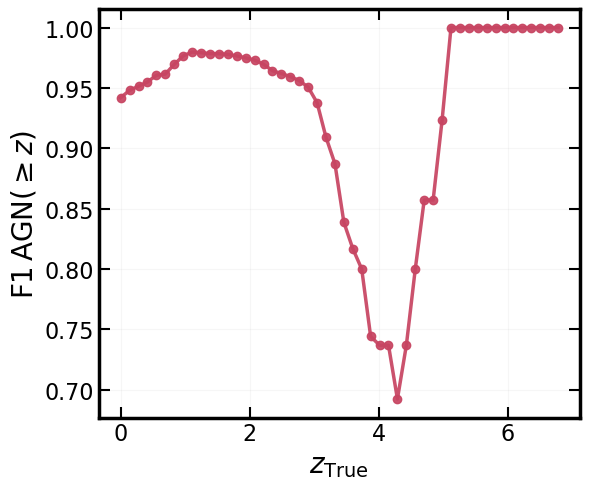

In [46]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, F1_AGN_z_lin, 'F1\,AGN', ax1, title=None)
if save_plot_flag:
    plt.savefig(f'plots/F1_AGN_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

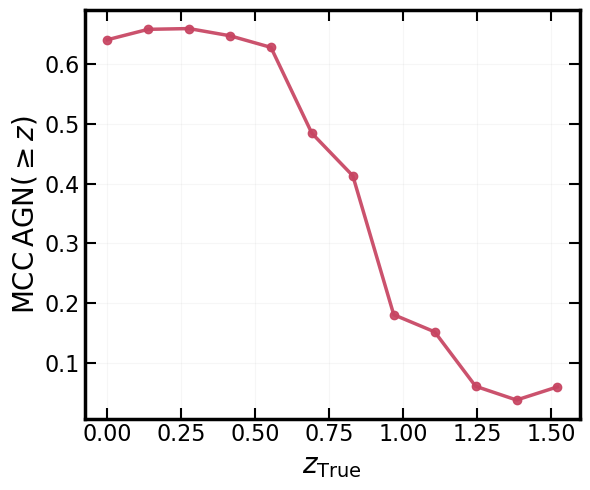

In [47]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, MCC_AGN_z_lin, 'MCC\,AGN', ax1, title=None)
if save_plot_flag:
    plt.savefig(f'plots/MCC_AGN_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

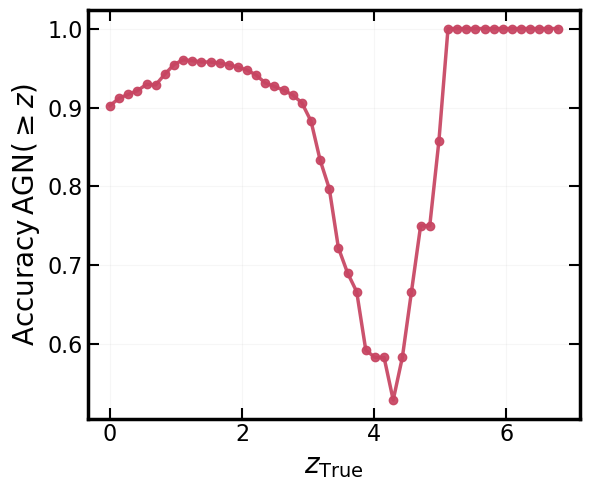

In [48]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, ACC_AGN_z_lin, 'Accuracy\,AGN', ax1, title=None)
if save_plot_flag:
    plt.savefig(f'plots/Accuracy_AGN_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

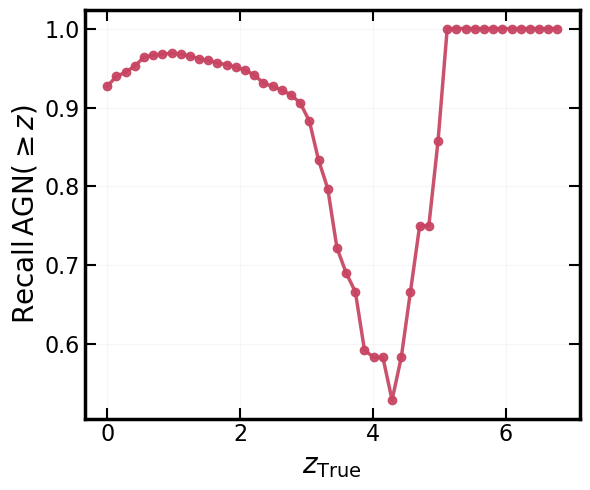

In [49]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, Rec_AGN_z_lin, 'Recall\,AGN', ax1, title=None)
if save_plot_flag:
    plt.savefig(f'plots/Recall_AGN_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

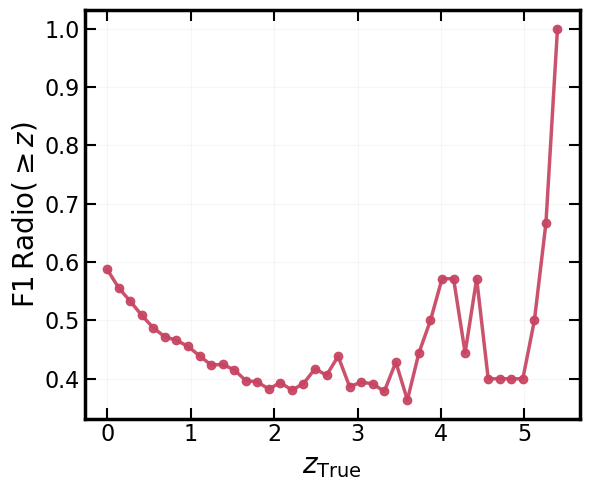

In [50]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, F1_radio_z_lin, 'F1\,Radio', ax1, title=None)
if save_plot_flag:
    plt.savefig(f'plots/F1_radio_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

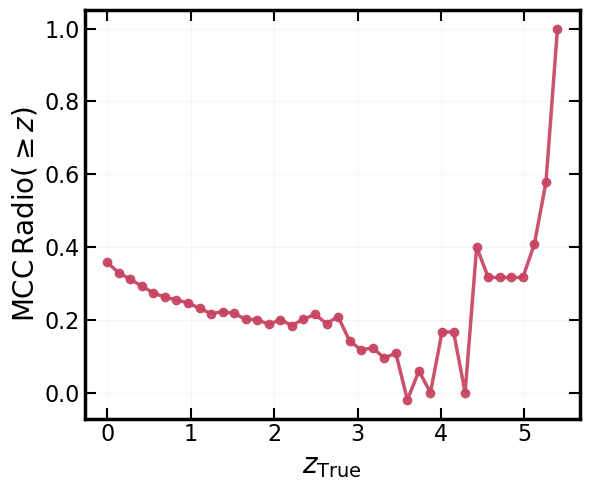

In [51]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, MCC_radio_z_lin, 'MCC\,Radio', ax1, title=None)
if save_plot_flag:
    plt.savefig(f'plots/MCC_radio_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

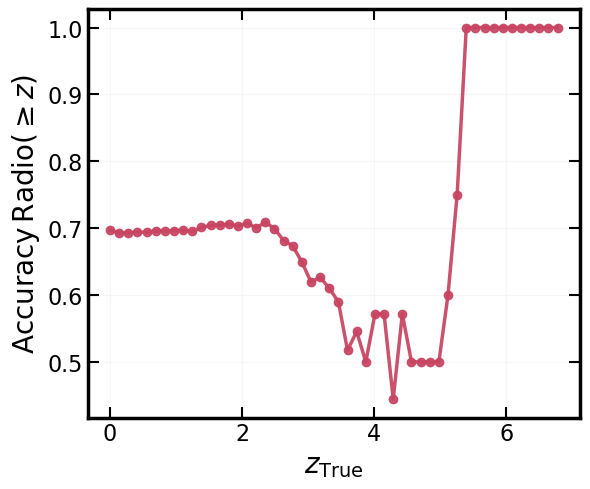

In [52]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, ACC_radio_z_lin, 'Accuracy\,Radio', ax1, title=None)
if save_plot_flag:
    plt.savefig(f'plots/Accuracy_radio_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

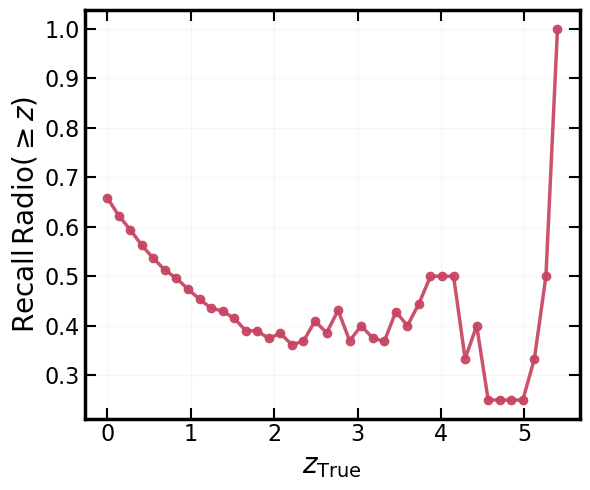

In [53]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, Rec_radio_z_lin, 'Recall\,Radio', ax1, title=None)
if save_plot_flag:
    plt.savefig(f'plots/Recall_radio_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

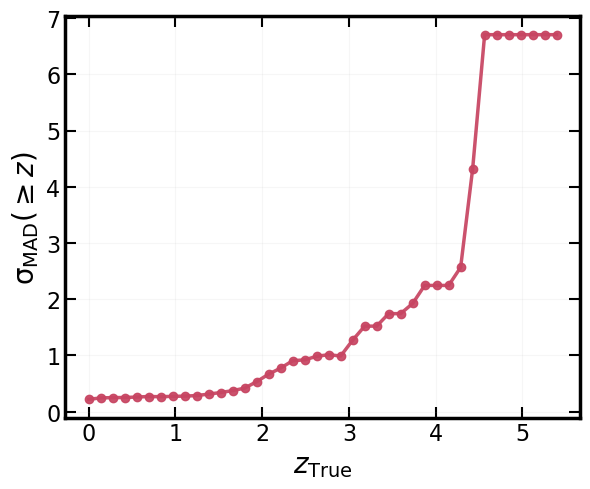

In [54]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_MAD_z_z_lin, '\sigma_{MAD}', ax1, title=None)
if save_plot_flag:
    plt.savefig(f'plots/sigma_MAD_z_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

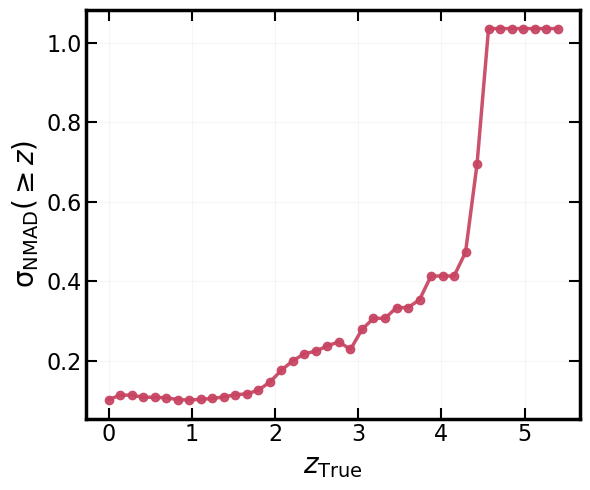

In [55]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_NMAD_z_z_lin, '\sigma_{NMAD}', ax1, title=None)
if save_plot_flag:
    plt.savefig(f'plots/sigma_NMAD_z_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

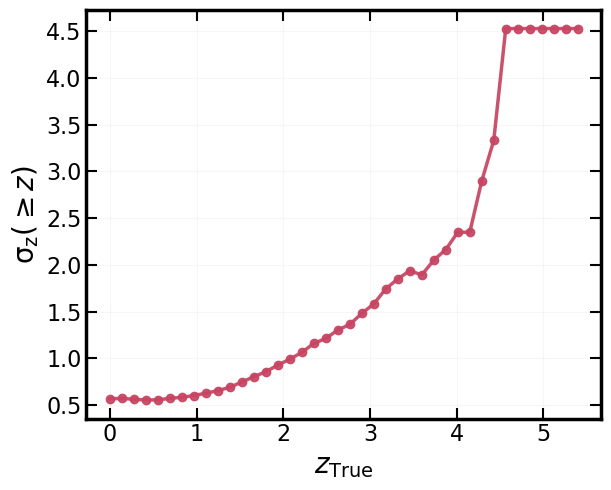

In [56]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, sigma_z_z_z_lin, '\sigma_{z}', ax1, title=None)
if save_plot_flag:
    plt.savefig(f'plots/sigma_z_z_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

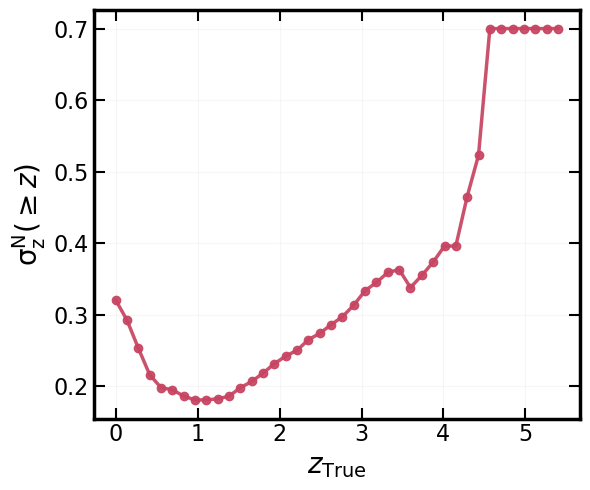

In [57]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, sigma_z_N_z_z_lin, '\sigma_{z}^{N}', ax1, title=None)
if save_plot_flag:
    plt.savefig(f'plots/sigma_z_N_z_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

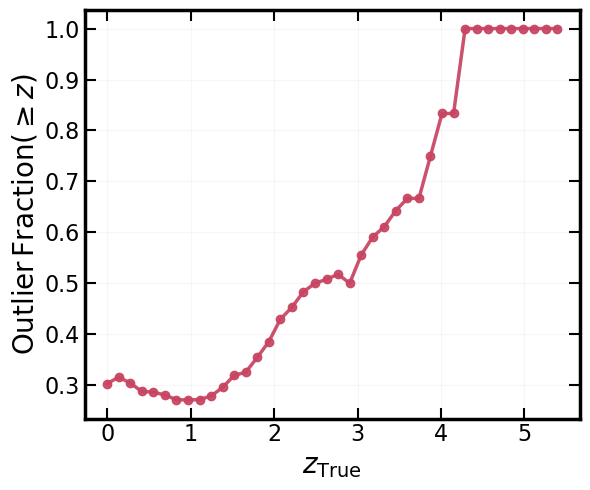

In [58]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, out_fr_z_z_lin, 'Outlier\,Fraction', ax1, title=None)
if save_plot_flag:
    plt.savefig(f'plots/Out_fraction_z_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

---

## Create plots for evolution of some metrics (Recall) with selected threshold

In [59]:
thresh_range_AGN       = np.linspace(catalog_for_AGN.loc[:, 'Score_AGN'].min(),     catalog_for_AGN.loc[:, 'Score_AGN'].max(), num=100)
thresh_range_radio     = np.linspace(catalog_for_radio.loc[:, 'Score_radio'].min(), catalog_for_radio.loc[:, 'Score_radio'].max(), num=100)

In [60]:
recall_vs_thresh_AGN   = metric_over_threshold(catalog_for_AGN,   'class',\
                                               'Score_AGN',    thresh_range_AGN, Recall_from_CM)
MCC_vs_thresh_AGN      = metric_over_threshold(catalog_for_AGN,   'class',\
                                               'Score_AGN',    thresh_range_AGN, MCC_from_CM)

recall_vs_thresh_radio = metric_over_threshold(catalog_for_radio, 'radio_detect',\
                                               'Score_radio', thresh_range_radio, Recall_from_CM)
F1_vs_thresh_radio    = metric_over_threshold(catalog_for_AGN,   'radio_detect',\
                                               'Score_radio',    thresh_range_AGN, F1_from_CM)

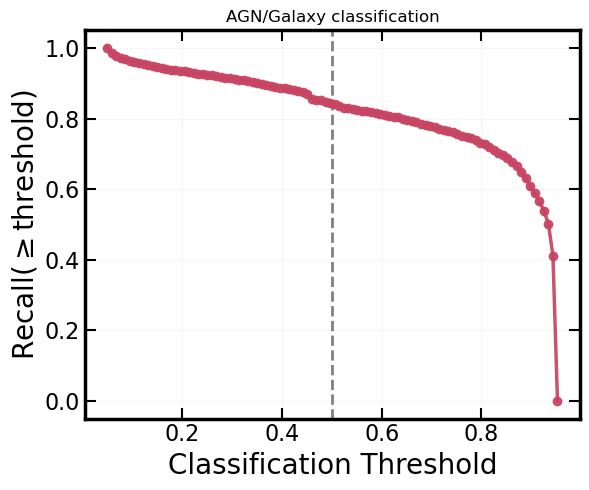

In [61]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_threshold(thresh_range_AGN, recall_vs_thresh_AGN, 'Recall', ax1, title='AGN/Galaxy classification')
if save_plot_flag:
    plt.savefig(f'plots/Recall_AGN_threshold_{used_area}.pdf', bbox_inches='tight')
plt.show()

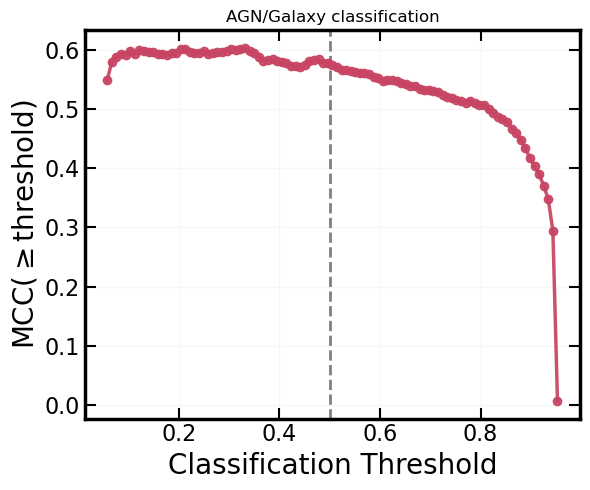

In [62]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_threshold(thresh_range_AGN, MCC_vs_thresh_AGN, 'MCC', ax1, title='AGN/Galaxy classification')
if save_plot_flag:
    plt.savefig(f'plots/MCC_AGN_threshold_{used_area}.pdf', bbox_inches='tight')
plt.show()

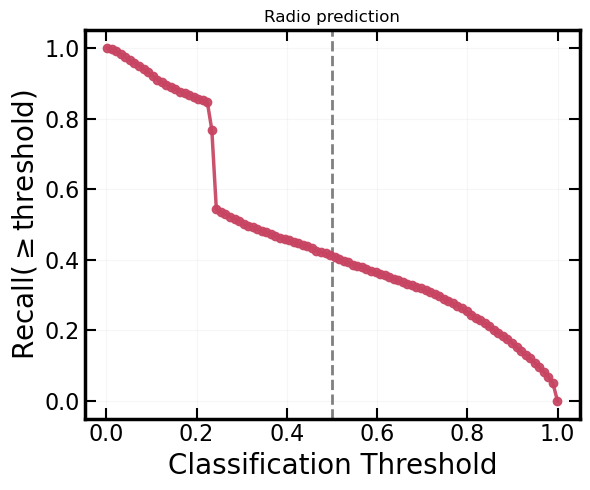

In [63]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_threshold(thresh_range_radio, recall_vs_thresh_radio, 'Recall', ax1, title='Radio prediction')
if save_plot_flag:
    plt.savefig(f'plots/Recall_radio_threshold_{used_area}.pdf', bbox_inches='tight')
plt.show()

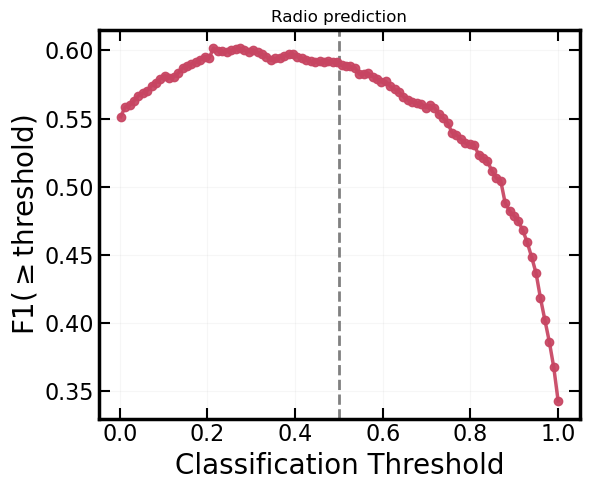

In [64]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_threshold(thresh_range_radio, F1_vs_thresh_radio, 'F1', ax1, title='Radio prediction')
if save_plot_flag:
    plt.savefig(f'plots/F1_radio_threshold_{used_area}.pdf', bbox_inches='tight')
plt.show()